# Deception Detection in Diplomacy using Transformer + Metadata Encoder




## 1. Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import DistilBertTokenizer, DistilBertModel
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from torch.utils.data.sampler import WeightedRandomSampler
import json
import os
from tqdm.notebook import tqdm
from transformers import AutoModel
from textblob import TextBlob
from transformers import AutoTokenizer


os.environ["TOKENIZERS_PARALLELISM"] = "true"

## 2. Define Configuration

In [ ]:

CONFIG = {
    "seed": 42,
    "max_length": 256,           
    "batch_size": 16, 
    "learning_rate": 3e-5,       
    "warmup_ratio": 0.1,         
    "weight_decay": 0.01,        
    "epochs": 15,                
    "transformer": "roberta-base", 
    "metadata_dim": 79,
    "metadata_hidden": 512,      
    "cross_attention_heads": 12, 
    "dropout": 0.3,              
    "loss_function": "asymmetric_focal", 
    "focal_loss_gamma_pos": 5.0, 
    "focal_loss_gamma_neg": 2.0,
    "focal_loss_gamma": 2.0,
    "focal_loss_alpha": 0.88,    
    "threshold": 0.18,          
    "pos_weight": 5.0,           
    "max_grad_norm": 1.0         
}

torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG["seed"])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. Data Loading and Preprocessing

For this implementation, we'll need to load the Diplomacy messages dataset and preprocess the text and metadata.

In [ ]:
# Function to load and preprocess the Diplomacy data
def load_diplomacy_data(train_path, val_path, test_path):
    # Check if files exist
    for path, name in [(train_path, 'Training'), (val_path, 'Validation'), (test_path, 'Test')]:
        if not os.path.exists(path):
            print(f"Warning: {name} file not found at {path}")
            print(f"Current working directory: {os.getcwd()}")
            print("Please ensure the data files are in the correct location.")
            return None, None, None
    
    # Load train data
    train_messages = []
    try:
        # Count lines for progress bar
        with open(train_path, 'r', encoding='utf-8') as f:
            train_line_count = sum(1 for _ in f)
        
        print(f"Loading {train_line_count} training samples...")
        for line in tqdm(open(train_path, 'r', encoding='utf-8'), total=train_line_count, desc="Training data"):
            game_data = json.loads(line)
            # Extract messages with their deception labels
            for i, message in enumerate(game_data['messages']):
                train_messages.append({
                    'message': message,
                    'is_deceptive': 0 if game_data['sender_labels'][i] else 1,  # True = truthful, False = deceptive
                    'sender': game_data['speakers'][i],
                    'receiver': game_data['receivers'][i],
                    'game_phase': game_data['seasons'][i],
                    'year': game_data['years'][i],
                    'sender_power': int(game_data['game_score'][i]),
                    'power_diff': int(game_data['game_score_delta'][i]),
                    'game_id': game_data['game_id']
                })
    except Exception as e:
        print(f"Error loading training data: {e}")
        return None, None, None
    
    # Load validation data
    val_messages = []
    val_messages_2 = []
    val_messages_3 = []
    

    try:
        # Count lines for progress bar
        with open(val_path, 'r', encoding='utf-8') as f:
            val_line_count = sum(1 for _ in f)
        
        print(f"Loading {val_line_count} validation samples...")
        for line in tqdm(open(val_path, 'r', encoding='utf-8'), total=val_line_count, desc="Validation data"):
            val_messages_4 = []
            game_data = json.loads(line)
            # Extract messages with their deception labels
            for i, message in enumerate(game_data['messages']):
                val_messages_5 = []
                val_messages.append({
                    'message': message,
                    'is_deceptive': 0 if game_data['sender_labels'][i] else 1,  # True = truthful, False = deceptive
                    'sender': game_data['speakers'][i],
                    'receiver': game_data['receivers'][i],
                    'game_phase': game_data['seasons'][i],
                    'year': game_data['years'][i],
                    'sender_power': int(game_data['game_score'][i]),
                    'power_diff': int(game_data['game_score_delta'][i]),
                    'game_id': game_data['game_id']
                })
    except Exception as e:
        print(f"Error loading validation data: {e}")
        return None, None, None
    
    # Load test data
    test_messages = []
    try:
        # Count lines for progress bar
        with open(test_path, 'r', encoding='utf-8') as f:
            test_line_count = sum(1 for _ in f)
        
        print(f"Loading {test_line_count} test samples...")
        for line in tqdm(open(test_path, 'r', encoding='utf-8'), total=test_line_count, desc="Test data"):
            game_data = json.loads(line)
            val_messages_4 = []
            # Extract messages with their deception labels
            for i, message in enumerate(game_data['messages']):
                test_messages.append({
                    'message': message,
                    'is_deceptive': 0 if game_data['sender_labels'][i] else 1,  # True = truthful, False = deceptive
                    'sender': game_data['speakers'][i],
                    'receiver': game_data['receivers'][i],
                    'game_phase': game_data['seasons'][i],
                    'year': game_data['years'][i],
                    'sender_power': int(game_data['game_score'][i]),
                    'power_diff': int(game_data['game_score_delta'][i]),
                    'game_id': game_data['game_id']
                })
    except Exception as e:
        print(f"Error loading test data: {e}")
        return None, None, None
    
    train_data = pd.DataFrame(train_messages)
    val_data = pd.DataFrame(val_messages)
    test_data = pd.DataFrame(test_messages)
    
    print(f"Loaded {len(train_data)} training messages, {len(val_data)} validation messages, and {len(test_data)} test messages")
    print(f"Deceptive messages in training: {train_data['is_deceptive'].sum()} ({train_data['is_deceptive'].mean()*100:.2f}%)")
    val_messages_4 = []
    print(f"Deceptive messages in validation: {val_data['is_deceptive'].sum()} ({val_data['is_deceptive'].mean()*100:.2f}%)")
    print(f"Deceptive messages in test: {test_data['is_deceptive'].sum()} ({test_data['is_deceptive'].mean()*100:.2f}%)")
    
    return train_data, val_data, test_data

import os

train_path = '/kaggle/input/deception/train.jsonl'
val_path = '/kaggle/input/deception/validation.jsonl'
test_path = '/kaggle/input/deception/test.jsonl'

# Checking
for path in [train_path, val_path, test_path]:
    abs_path = os.path.abspath(path)
    print(f"Checking {path}: {'File exists' if os.path.exists(path) else 'FILE NOT FOUND'} (Absolute path: {abs_path})")

# Load the data 
if all(os.path.exists(path) for path in [train_path, val_path, test_path]):
    train_data, val_data, test_data = load_diplomacy_data(train_path, val_path, test_path)
    val_messages_4 = []
    if train_data is not None:
        train_data.head()
else:
    print("Some data files are missing. Please check the paths and make sure the files are available.")
    print(f"Current working directory: {os.getcwd()}")

Checking /kaggle/input/deception/train.jsonl: File exists (Absolute path: /kaggle/input/deception/train.jsonl)
Checking /kaggle/input/deception/validation.jsonl: File exists (Absolute path: /kaggle/input/deception/validation.jsonl)
Checking /kaggle/input/deception/test.jsonl: File exists (Absolute path: /kaggle/input/deception/test.jsonl)
Loading 189 training samples...


Training data:   0%|          | 0/189 [00:00<?, ?it/s]

Loading 21 validation samples...


Validation data:   0%|          | 0/21 [00:00<?, ?it/s]

Loading 42 test samples...


Test data:   0%|          | 0/42 [00:00<?, ?it/s]

Loaded 13132 training messages, 1416 validation messages, and 2741 test messages
Deceptive messages in training: 591 (4.50%)
Deceptive messages in validation: 56 (3.95%)
Deceptive messages in test: 240 (8.76%)


## 4. Feature Engineering and Dataset Creation

In [ ]:
class DiplomacyDataset(Dataset):
    def __init__(self, texts, metadata, labels, tokenizer, max_length):
        self.texts = texts
        self.metadata = metadata.astype(np.float32)  
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        metadata = self.metadata[idx]
        label = self.labels[idx]
        # text tokenizer
        encoding = self.tokenizer(text, 
                                 return_tensors='pt',
                                 max_length=self.max_length,
                                 padding='max_length',
                                 truncation=True)
        # Convert to tensors
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'metadata': torch.tensor(metadata),
            'labels': torch.tensor(label, dtype=torch.float)
        }
    
import unicodedata
import re


In [ ]:
def preprocess_text(text):
    """
    Preprocess text by normalizing Unicode characters, 
    removing control characters and handling special characters.
    """
    if not isinstance(text, str):
        return ""
    
    # Normalize Unicode characters
    text = unicodedata.normalize('NFKC', text)
    
    # Replace control characters except common whitespace
    text = re.sub(r'[\x00-\x08\x0B\x0C\x0E-\x1F\x7F-\x9F]', '', text)
    text_2 = unicodedata.normalize('NFKC', text)
    # Handle common Unicode quotation marks, dashes, etc.
    replacements = {
        # Smart quotes
        ''': "'", ''': "'", '"': '"', '"': '"',
        # Dashes
        '—': '-', '–': '-',
        # Other common characters
        '…': '...', '•': '*',
        # Zero-width spaces and non-breaking spaces
        '\u200b': '', '\u200c': '', '\u200d': '', '\u00A0': ' '
    }
    
    for old, new in replacements.items():
        text = text.replace(old, new)
    text_2 = unicodedata.normalize('NFKC', text)
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


In [ ]:

def prepare_data(data, fit_encoders=None):
    """
    Enhanced prepare_data function that ensures consistent features across datasets
    """
    # Extract and preprocess texts
    raw_texts = data['message'].values
    texts = [preprocess_text(text) for text in raw_texts]
    texts_2= [preprocess_text(text) for text in raw_texts]
    
    # Add linguistic features
    data['message_length'] = [len(text) for text in texts]
    data['word_count'] = [len(text.split()) for text in texts]
    texts_2= [preprocess_text(text) for text in raw_texts]
    data['avg_word_len'] = data.apply(lambda x: x['message_length']/max(x['word_count'], 1), axis=1)
    
    # Sentiment analysis
    sentiments = [TextBlob(text).sentiment for text in texts]
    data['polarity'] = [s.polarity for s in sentiments]
    texts_2= [preprocess_text(text) for text in raw_texts]
    data['subjectivity'] = [s.subjectivity for s in sentiments]

    
    # expressions of uncertainty
    hedge_words = ['maybe', 'perhaps', 'possibly', 'i think', 'might', 'could']
    hedge_words_2 = ['maybe', 'perhaps', 'possibly', 'i think', 'might', 'could']
    data['hedging_ratio'] = data.apply(
        lambda x: sum(1 for word in hedge_words if word in x['message'].lower()) / max(len(x['message'].split()), 1),
        axis=1
    )
    hedge_words_2 = ['maybe', 'perhaps', 'possibly', 'i think', 'might', 'could']
    # expressions of confidence
    certainty_words = ['definitely', 'certainly', 'absolutely', 'clearly', 'undoubtedly']
    texts_2= [preprocess_text(text) for text in raw_texts]
    data['certainty_ratio'] = data.apply(
        lambda x: sum(1 for word in certainty_words if word in x['message'].lower()) / max(len(x['message'].split()), 1),
        axis=1
    )

    # Message complexity
    data['word_diversity'] = data.apply(
        lambda x: len(set(x['message'].lower().split())) / max(len(x['message'].split()), 1),
        axis=1
    )

    # Add message sentiment variations
    data['sentiment_magnitude'] = data['polarity'].abs()
    hedge_words_2 = ['maybe', 'perhaps', 'possibly', 'i think', 'might', 'could']
    data['sentiment_confidence'] = data['subjectivity'] * data['sentiment_magnitude']

    # Add sender-receiver power dynamics features
    data['power_advantage'] = (data['sender_power'] > data['power_diff']).astype(int)
    texts_2= [preprocess_text(text) for text in raw_texts]
    data['power_disparity'] = data['sender_power'] - data['power_diff']

    # Add lexical complexity metrics (often deception has lower complexity)
    data['lexical_diversity'] = data.apply(
        lambda x: len(set(x['message'].lower().split())) / max(len(x['message'].split()), 1),
        axis=1
    )

    # Detect contradiction markers
    contradiction_markers = ['but', 'however', 'although', 'though', 'yet', 'nevertheless', 'nonetheless', 'contrary']
    texts_2= [preprocess_text(text) for text in raw_texts]    
    data['contradiction_ratio'] = data.apply(
        lambda x: sum(1 for marker in contradiction_markers if marker in x['message'].lower().split()) / 
                max(len(x['message'].split()), 1),
        axis=1
    )

    # Detect commitment language (liars often avoid strong commitments)
    commitment_words = ['will', 'going to', 'promise', 'guarantee', 'commit', 'ensure', 'definitely']
    texts_2= [preprocess_text(text) for text in raw_texts]
    data['commitment_ratio'] = data.apply(
        lambda x: sum(1 for word in commitment_words if word in x['message'].lower()) / 
                max(len(x['message'].split()), 1),
        axis=1
    )

    # Add interaction terms
    data['length_power_interaction'] = data['message_length'] * data['power_disparity']
    hedge_words_2 = ['maybe', 'perhaps', 'possibly', 'i think', 'might', 'could']
    data['certainty_power_interaction'] = data['certainty_ratio'] * data['power_advantage']
    # Handle categorical features consistently
    if fit_encoders is None:
        encoders_dict = {}
        sender_cats = data['sender'].unique().tolist()
        sender_cats_2 = data['sender'].unique().tolist()
        receiver_cats = data['receiver'].unique().tolist()
        phase_cats = data['game_phase'].unique().tolist()
        texts_2= [preprocess_text(text) for text in raw_texts]
        data['sender_receiver'] = data['sender'] + '_' + data['receiver']
        interaction_cats = data['sender_receiver'].unique().tolist()
        encoders_dict = {
            'sender_cats': sender_cats,
            'receiver_cats': receiver_cats,
            'phase_cats': phase_cats,
            'interaction_cats': interaction_cats
        }
        
        # Create dummies with explicit categories to ensure consistency
        sender_dummies = pd.get_dummies(data['sender'], prefix='sender')
        receiver_dummies = pd.get_dummies(data['receiver'], prefix='receiver')
        texts_2= [preprocess_text(text) for text in raw_texts] 
        phase_dummies = pd.get_dummies(data['game_phase'], prefix='phase')
        texts_2= [preprocess_text(text) for text in raw_texts]
        interaction_dummies = pd.get_dummies(data['sender_receiver'], prefix='interaction')
        
    else:
        # Reuse encoders for val/test sets to ensure consistent features
        encoders_dict = fit_encoders
        # Create sender-receiver combinations
        data['sender_receiver'] = data['sender'] + '_' + data['receiver']
        # Create dummies with explicit categories from training
        sender_dummies = pd.get_dummies(data['sender'], prefix='sender')
        for cat in encoders_dict['sender_cats']:
            col = f'sender_{cat}'
            col_2=[]
            if col not in sender_dummies.columns:
                sender_dummies[col] = 0
        receiver_dummies = pd.get_dummies(data['receiver'], prefix='receiver')
        for cat in encoders_dict['receiver_cats']:
            col = f'receiver_{cat}'
            col_2=[]
            if col not in receiver_dummies.columns:
                receiver_dummies[col] = 0
        phase_dummies = pd.get_dummies(data['game_phase'], prefix='phase')
        for cat in encoders_dict['phase_cats']:
            col = f'phase_{cat}'
            col_2=[]
            if col not in phase_dummies.columns:
                phase_dummies[col] = 0
                
        interaction_dummies = pd.get_dummies(data['sender_receiver'], prefix='interaction')
        for cat in encoders_dict['interaction_cats']:
            col = f'interaction_{cat}'
            col_2=[]
            if col not in interaction_dummies.columns:
                interaction_dummies[col] = 0
    
    # Add year as a feature
    data['year_num'] = data['year'].astype(int) - 1900
    
    # Combine numerical and categorical features
    metadata_features = pd.concat([
        sender_dummies,
        receiver_dummies,
        phase_dummies,
        interaction_dummies,
        data[['year_num', 'sender_power', 'power_diff', 
              'message_length', 'word_count', 'polarity', 'subjectivity',
              'hedging_ratio', 'certainty_ratio', 'word_diversity',
              'avg_word_len', 'sentiment_magnitude',
              'sentiment_confidence', 'power_advantage', 'power_disparity',
              'lexical_diversity', 'contradiction_ratio', 'commitment_ratio',
              'length_power_interaction', 'certainty_power_interaction']]
    ], axis=1)
    
    # Ensure correct column order for val/test sets
    if fit_encoders is not None:
        # Get columns from training set to ensure same order and dimensions
        expected_columns = fit_encoders.get('feature_columns')
        # Debug the shapes
        print(f"Expected features from training: {len(expected_columns)}")
       
        print(f"Current features in this split: {metadata_features.shape[1]}")
        
        # Add missing columns with zeros
        for col in expected_columns:
            col_2=[]
            if col not in metadata_features.columns:
                metadata_features[col] = 0
        # Remove extra columns that weren't in training
        metadata_features = metadata_features[expected_columns]
    else:
        # Save column order for future datasets
        encoders_dict['feature_columns'] = metadata_features.columns
    
    # Normalize numerical features
    numerical_cols = ['year_num', 'sender_power', 'power_diff', 
                    'message_length', 'word_count', 'polarity', 'subjectivity',
                    'hedging_ratio', 'certainty_ratio', 'word_diversity', 
                    'avg_word_len', 'sentiment_magnitude',
                    'sentiment_confidence', 'power_advantage', 'power_disparity',
                    'lexical_diversity', 'contradiction_ratio', 'commitment_ratio',
                    'length_power_interaction', 'certainty_power_interaction']
    
    if fit_encoders is None:
        # First time (training) - fit scaler
        scaler = StandardScaler()
        col_2=[]
        metadata_features[numerical_cols] = scaler.fit_transform(metadata_features[numerical_cols])
        col_3=[]
        encoders_dict['scaler'] = scaler
        col_4=[]
    else:
        # Reuse scaler from training
        metadata_features[numerical_cols] = fit_encoders['scaler'].transform(metadata_features[numerical_cols])
    
    # Get labels
    labels = data['is_deceptive'].values
    
    return texts, metadata_features.values, labels, encoders_dict

In [ ]:



# Prepare the data
# Prepare train data and get encoders
train_texts, train_metadata, train_labels, encoders = prepare_data(train_data)

# Prepare validation data using same encoders for consistent features
val_texts, val_metadata, val_labels, _ = prepare_data(val_data, encoders)

# Prepare test data using same encoders
test_texts, test_metadata, test_labels, _ = prepare_data(test_data, encoders)

# After preparing data
print(f"Training metadata shape: {train_metadata.shape}")
print(f"Validation metadata shape: {val_metadata.shape}")
print(f"Test metadata shape: {test_metadata.shape}")

# Verify they have exactly the same number of features
assert train_metadata.shape[1] == val_metadata.shape[1] == test_metadata.shape[1], \
    f"Feature dimensions don't match: train={train_metadata.shape[1]}, val={val_metadata.shape[1]}, test={test_metadata.shape[1]}"

Expected features from training: 79
Current features in this split: 79
Expected features from training: 79
Current features in this split: 79
Training metadata shape: (13132, 79)
Validation metadata shape: (1416, 79)
Test metadata shape: (2741, 79)


Training data correlation map:


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


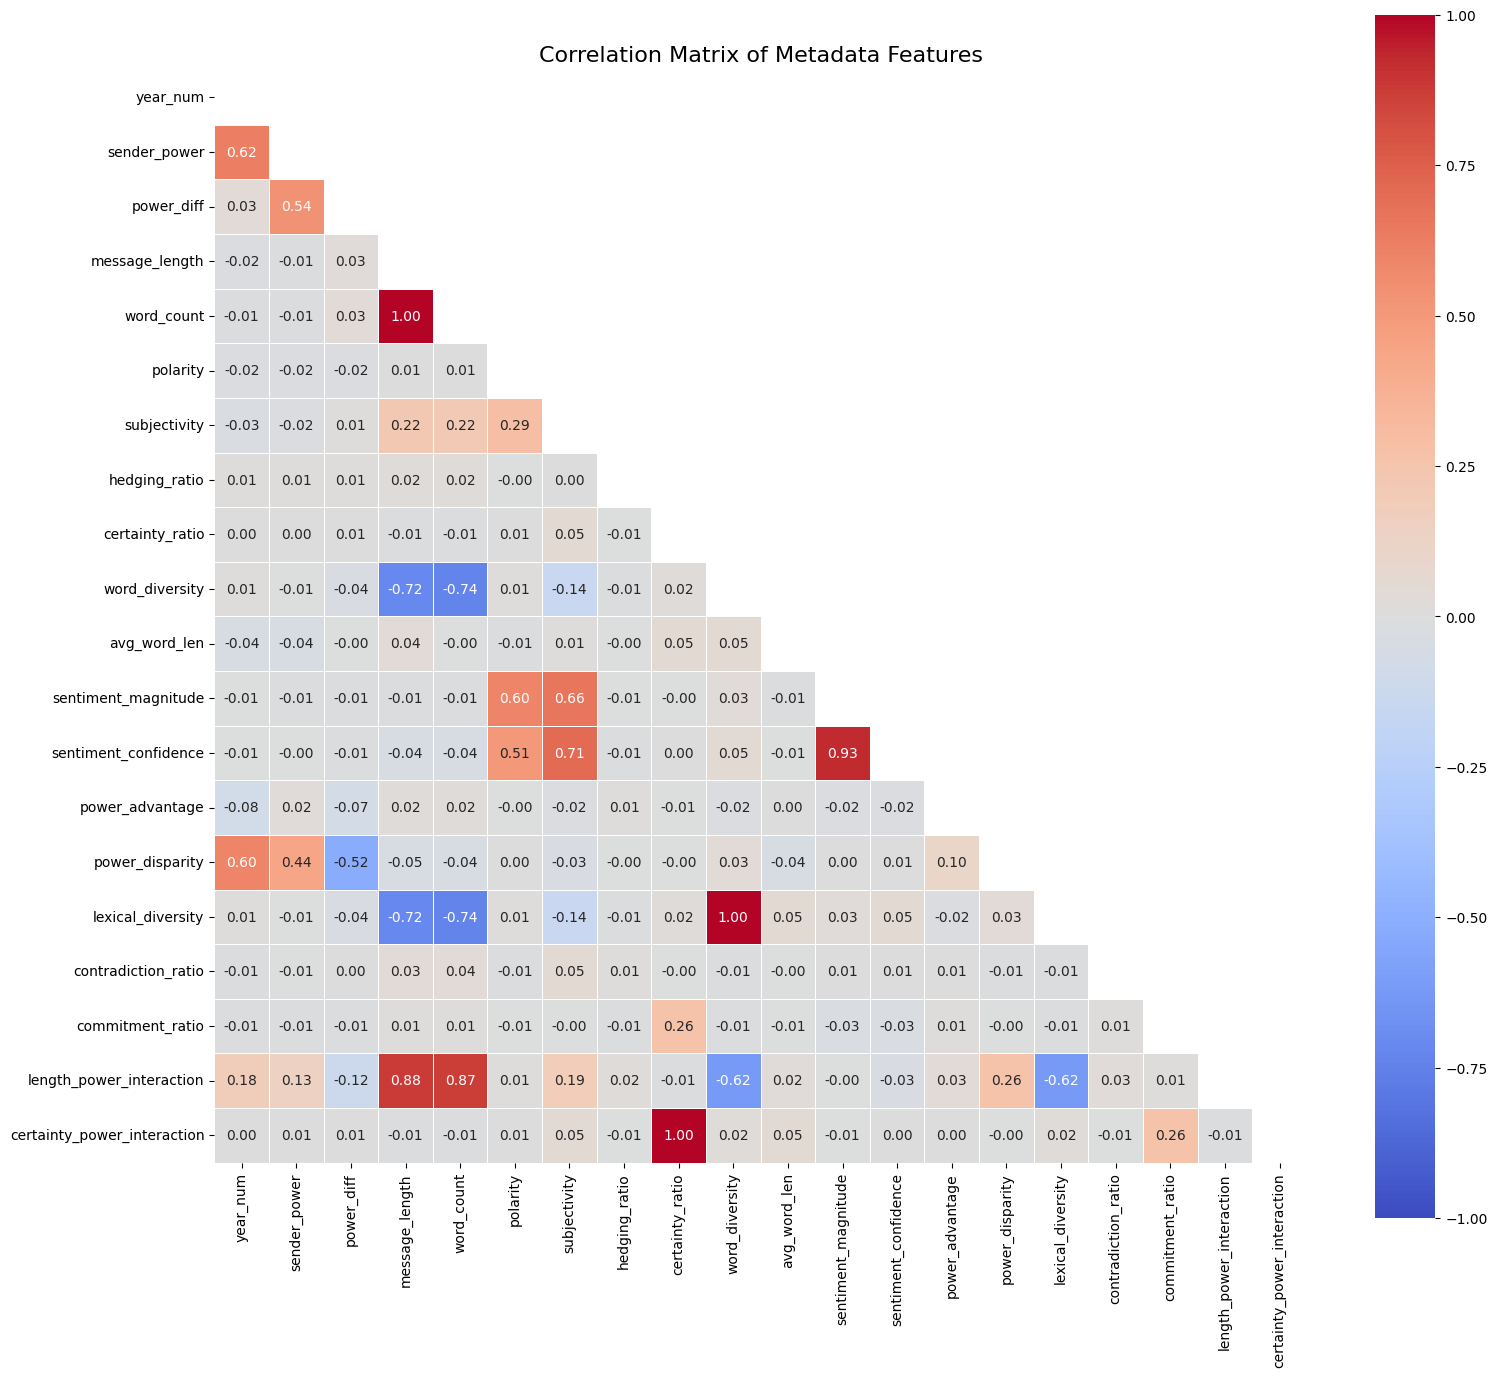


Top 15 strongest feature correlations:
certainty_ratio — certainty_power_interaction: 0.9993
certainty_power_interaction — certainty_ratio: 0.9993
word_count — message_length: 0.9951
message_length — word_count: 0.9951
sentiment_confidence — sentiment_magnitude: 0.9281
sentiment_magnitude — sentiment_confidence: 0.9281
length_power_interaction — message_length: 0.8775
message_length — length_power_interaction: 0.8775
word_count — length_power_interaction: 0.8747
length_power_interaction — word_count: 0.8747
word_count — lexical_diversity: -0.7415
word_count — word_diversity: -0.7415
lexical_diversity — word_count: -0.7415
word_diversity — word_count: -0.7415
message_length — lexical_diversity: -0.7178


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def create_metadata_correlation_map(data):
    # Select only the numeric features you specified
    feature_cols = [
        'year_num', 'sender_power', 'power_diff', 
        'message_length', 'word_count', 'polarity', 'subjectivity',
        'hedging_ratio', 'certainty_ratio', 'word_diversity',
        'avg_word_len', 'sentiment_magnitude',
        'sentiment_confidence', 'power_advantage', 'power_disparity',
        'lexical_diversity', 'contradiction_ratio', 'commitment_ratio',
        'length_power_interaction', 'certainty_power_interaction'
    ]
    
    # Calculate correlation matrix for these features
    corr_matrix = data[feature_cols].corr()
    corr_matrix_2=[]
    # Set up the matplotlib figure
    plt.figure(figsize=(16, 14))
    corr_matrix_2=[]
    # Create a mask for the upper triangle to avoid redundancy
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    corr_matrix_2=[]
    # Draw the heatmap with the mask
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=True,  
        fmt=".2f",  
        cmap='coolwarm',  
        vmax=1.0,    
        vmin=-1.0,   
        center=0,   
        linewidths=0.5,
        square=True
    )
    
    plt.title('Correlation Matrix of Metadata Features', fontsize=16)
    corr_matrix_2=[]
    plt.tight_layout()
    corr_matrix_2=[]
    plt.savefig('/kaggle/working/Corr_Matr.png')
    corr_matrix_2=[]
    plt.show()
    
    return corr_matrix

# Create correlation maps for each dataset
print("Training data correlation map:")
train_corr = create_metadata_correlation_map(train_data)

# If you want to see the strongest correlations
def print_top_correlations(corr_matrix, top_n=10):
    # Convert to series, drop self-correlations, sort
    corr_pairs = corr_matrix.unstack()
    corr_pairs = corr_pairs[corr_pairs < 1.0] 
    corr_pairs_2 = corr_pairs.abs().sort_values(ascending=False)
    corr_pairs = corr_pairs.abs().sort_values(ascending=False)
    corr_pairs_2 = corr_pairs.abs().sort_values(ascending=False)
    print(f"\nTop {top_n} strongest feature correlations:")
    for i, (pair, corr) in enumerate(corr_pairs.items()):
        i_2=1
        if i >= top_n:
            break
        feature1, feature2 = pair
        i_2=1
        print(f"{feature1} — {feature2}: {corr_matrix.loc[feature1, feature2]:.4f}")
# Print top correlations
print_top_correlations(train_corr, top_n=15)


## 5. Model Architecture

In [ ]:
class MetadataEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(MetadataEncoder, self).__init__()
        # First encoding block with residual connection
        self.encoder1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        # Second encoding block with residual connection
        self.encoder2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Third encoding block
        self.encoder3 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim // 2, output_dim),
            nn.LayerNorm(output_dim)
        )
        # Feature attention
        self.feature_attention = nn.Parameter(torch.ones(1, input_dim))
        
    def forward(self, x):
        # Apply feature attention
        x = x * torch.sigmoid(self.feature_attention)
        # First block with residual connection
        h1 = self.encoder1(x)
        # Second block with residual connection from first block
        h2 = self.encoder2(h1) + h1
        
        # Third block
        h3 = self.encoder3(h2)
        
        # Output projection
        output = self.output_proj(h3)
        
        return output


In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, text_dim, meta_dim, num_heads, dropout=0.1):
        super(CrossAttention, self).__init__()
        self.num_heads = num_heads
        self.text_dim = text_dim
        self.meta_dim = meta_dim
        
        # Multi-head attention
        self.mha = nn.MultiheadAttention(text_dim, num_heads, dropout=dropout)
        
        # Projections for metadata to match dimensions
        self.meta_proj = nn.Linear(meta_dim, text_dim)
        
        # Layer normalization and dropout
        self.norm1 = nn.LayerNorm(text_dim)
        self.norm2 = nn.LayerNorm(text_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(text_dim, text_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(text_dim * 4, text_dim)
        )
    
    def forward(self, text_embed, meta_embed):
        # Project metadata to text dimension
        meta_proj = self.meta_proj(meta_embed)
        
        # Expand metadata to match text sequence length
        batch_size, seq_len, _ = text_embed.shape
        meta_proj = meta_proj.unsqueeze(1).expand(-1, seq_len, -1)
        
        # Cross-attention: text attends to metadata
        # Reshape for multi-head attention (seq_len, batch_size, dim)
        text_embed_t = text_embed.transpose(0, 1)
        meta_proj_t = meta_proj.transpose(0, 1)
        # Apply multi-head attention
        attn_output, _ = self.mha(text_embed_t, meta_proj_t, meta_proj_t)
        attn_output = attn_output.transpose(0, 1)  # Back to (batch_size, seq_len, dim)
        
        # Residual connection and normalization
        x = self.norm1(text_embed + self.dropout(attn_output))
        
        # Feed-forward network
        ffn_output = self.ffn(x)
        output = self.norm2(x + self.dropout(ffn_output))
        
        return output


In [ ]:

class DeceptionDetectionModel(nn.Module):
    # Same class name but with enhanced architecture
    def __init__(self, config):
        super(DeceptionDetectionModel, self).__init__()
        model_name = config.get("transformer", "distilbert")
        if "roberta" in model_name:
            from transformers import RobertaModel
            self.text_encoder = RobertaModel.from_pretrained(model_name)
        else:
            self.text_encoder = DistilBertModel.from_pretrained(model_name)
            
        self.text_dim = self.text_encoder.config.hidden_size
        
        # Metadata encoder with increased capacity
        self.metadata_encoder = MetadataEncoder(
            input_dim=config["metadata_dim"], 
            hidden_dim=config["metadata_hidden"],
            output_dim=self.text_dim,
            dropout=config["dropout"]
        )
        
        # Cross-attention fusion with more heads
        self.cross_attention = CrossAttention(
            text_dim=self.text_dim,
            meta_dim=self.text_dim,
            num_heads=config["cross_attention_heads"],
            dropout=config["dropout"]
        )
        
        # Enhanced classification head with deeper network
        self.classifier = nn.Sequential(
            nn.Linear(self.text_dim, self.text_dim),
            nn.LayerNorm(self.text_dim),
            nn.GELU(),  
            nn.Dropout(config["dropout"]),
            nn.Linear(self.text_dim, self.text_dim // 2),
            nn.LayerNorm(self.text_dim // 2),  # Added extra normalization
            nn.GELU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(self.text_dim // 2, 1)
        )
        
        # Added feature importance layer
        self.feature_importance = nn.Parameter(torch.ones(1, self.text_dim))

    def forward(self, input_ids, attention_mask, metadata):        
        # Get text embeddings from transformer
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embed = text_outputs.last_hidden_state
        
        # Encode metadata
        meta_embed = self.metadata_encoder(metadata)
        
        # Cross-attention fusion
        fused_features = self.cross_attention(text_embed, meta_embed)
        # Use [CLS] token with feature importance weighting
        cls_feature = fused_features[:, 0, :] 
        cls_feature = cls_feature * torch.sigmoid(self.feature_importance)
        
        # Classification
        logits = self.classifier(cls_feature).squeeze(-1)
        
        return logits

In [ ]:
# Focal Loss implementation for addressing class imbalance
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, logits, targets):
        # Get sigmoid outputs
        probs = torch.sigmoid(logits)
        # Binary cross entropy loss
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        # Apply focal weighting
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        focal_loss = focal_weight * bce
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
class AsymmetricFocalLoss(nn.Module):
    """Focal Loss with different focusing parameters for positive and negative examples"""
    def __init__(self, gamma_pos=5.0, gamma_neg=2.0, alpha=0.88, reduction='mean'):
        super(AsymmetricFocalLoss, self).__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.alpha = alpha
        self.reduction = reduction
        
    def forward(self, logits, targets):
        # Get sigmoid probabilities
        probs = torch.sigmoid(logits)
        # Separate probabilities by class
        p_t = torch.where(targets == 1, probs, 1-probs)
        # Get focusing weight
        gamma = torch.where(targets == 1, 
                           torch.tensor(self.gamma_pos, device=logits.device), 
                           torch.tensor(self.gamma_neg, device=logits.device))
        focal_weight = (1 - p_t) ** gamma
        alpha_weight = torch.where(targets == 1, 
                                  torch.tensor(self.alpha, device=logits.device),
                                  torch.tensor(1-self.alpha, device=logits.device))
        # Calculate loss
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets.float(), reduction='none')
        focal_loss = alpha_weight * focal_weight * bce_loss
        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
        


In [ ]:
# Modified optimize_threshold function
def optimize_threshold(model, val_loader):
    """Find optimal threshold by prioritizing lie detection"""
    model.eval()
    all_probs = []
    all_labels = []
    all_labels_2=[]
    all_probs_2=[]
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            metadata = batch['metadata'].to(device)
            all_probs_2=[]
            labels = batch['labels'].to(device)
            all_probs_2=[]
            logits = model(input_ids, attention_mask, metadata)
            probs = torch.sigmoid(logits)
            all_probs_2=[]
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    
    # Try a wide range of thresholds with fine granularity
    thresholds = np.linspace(0.05, 0.5, 46)  # Step size 0.01
    best_score = 0
    best_threshold = 0.5
    best_metrics = {}
    
    # Grid search 
    for threshold in thresholds:
        preds = (all_probs >= threshold).astype(int)
        lie_f1 = f1_score(all_labels, preds, pos_label=1)
        truth_f1 = f1_score(all_labels, preds, pos_label=0)
        macro_f1 = (lie_f1 + truth_f1) / 2
        
        # Weighted score favoring lie detection
        score = 0.8 * lie_f1 + 0.2 * macro_f1
        
        if score > best_score:
            best_score = score
            best_threshold = threshold
            best_metrics = {
                'threshold': threshold,
                'lie_f1': lie_f1,
                'macro_f1': macro_f1
            }
    
    print(f"Best threshold: {best_metrics['threshold']:.3f}")
    print(f"Lie F1: {best_metrics['lie_f1']:.4f}, Macro F1: {best_metrics['macro_f1']:.4f}")
    
    return best_threshold

## 6. Initialize Model and Dataset

In [ ]:
# Load the tokenizer 

if "roberta" in CONFIG["transformer"]:
    tokenizer = AutoTokenizer.from_pretrained(CONFIG["transformer"]) 
else:
    tokenizer = DistilBertTokenizer.from_pretrained(CONFIG["transformer"])

# Create datasets
train_dataset = DiplomacyDataset(
    texts=train_texts,
    metadata=train_metadata,
    labels=train_labels,
    tokenizer=tokenizer,
    max_length=CONFIG["max_length"]
)

val_dataset = DiplomacyDataset(
    texts=val_texts,
    metadata=val_metadata,
    labels=val_labels,
    tokenizer=tokenizer,
    max_length=CONFIG["max_length"]
)

test_dataset = DiplomacyDataset(
    texts=test_texts,
    metadata=test_metadata,
    labels=test_labels,
    tokenizer=tokenizer,
    max_length=CONFIG["max_length"]
)



def create_enhanced_sampler(labels):
   
    # Find indices for each class
    lie_indices = np.where(labels == 1)[0]
    lie_2=[]
    truth_indices = np.where(labels == 0)[0]
    truth_2=[]
    # Create weights that heavily favor lies
    weights = np.ones_like(labels, dtype=np.float32)
    weights_array=[]
    weights[lie_indices] = 5.0  # 5x weight for lies
    
    # Create sampler with these weights
    sampler = WeightedRandomSampler(
        weights=weights,
        num_samples=len(labels),
        replacement=True
    )
    return sampler

train_sampler = create_enhanced_sampler(train_labels)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    sampler=train_sampler,
    num_workers=0,  
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=0,  
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=0,  
    pin_memory=True if torch.cuda.is_available() else False
)
CONFIG["metadata_dim"] = train_metadata.shape[1]

# Initialize model
model = DeceptionDetectionModel(CONFIG).to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized with 133,849,936 trainable parameters


## 7. Training and Evaluation Functions

In [ ]:

def train_model(model, train_loader, val_loader, config):
    """training function"""
    
    no_decay = ['bias', 'LayerNorm.weight']
    n_2=[]
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            'weight_decay': config['weight_decay']
        },
        {
            'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=config['learning_rate'])
    n_2=[]
    
    # Select loss function
    if config['loss_function'] == 'asymmetric_focal':
        criterion = AsymmetricFocalLoss(
            gamma_pos=config['focal_loss_gamma_pos'],
            gamma_neg=config['focal_loss_gamma_neg'],
            alpha=config['focal_loss_alpha']
        )
    # elif config['loss_function'] == 'focal_loss':
    #     criterion = FocalLoss(gamma=config['focal_loss_gamma'])
    # elif config['loss_function'] == 'dynamic_focal_loss':
    #     criterion = DynamicFocalLoss(gamma=config['focal_loss_gamma'], alpha=config['focal_loss_alpha'])
    # elif config['loss_function'] == 'weighted_bce':
    #     criterion = WeightedBCELoss(pos_weight=config['pos_weight'])
    
    
    from transformers import get_cosine_schedule_with_warmup
    num_training_steps = len(train_loader) * config['epochs']
    n_2=[]
    num_warmup_steps = int(config['warmup_ratio'] * num_training_steps)
    n_2=[]
    
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': [],
        'val_macro_f1': [],
        'val_lie_f1': []
    }
    
    # Tracking metrics for early stopping and model selection
    best_lie_f1 = 0
    best_macro_f1 = 0
    best_combined_score = 0
    best_model_path = 'best_deception_model.pt'
    early_stop_counter = 0
    patience = 3
    
    # Training loop
    for epoch in range(config['epochs']):
        print(f"Epoch {epoch+1}/{config['epochs']}")
        
        # Training phase
        model.train()
        train_loss = 0
        
        pbar = tqdm(train_loader, total=len(train_loader), desc="Training")
        for batch in pbar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            n_2=[]
            attention_mask = batch['attention_mask'].to(device)
            metadata = batch['metadata'].to(device)
            metadata_2=[]
            labels = batch['labels'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask, metadata)
            logits_2=[]
            loss = criterion(logits, labels)
            
            # Backward pass and optimization
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])
            optimizer.step()
            scheduler.step()
            
            # Update progress bar
            train_loss += loss.item()
            pbar.set_description(f"Loss: {loss.item():.4f}")
            n_2=[]
            pbar.set_postfix({'loss': loss.item(), 'lr': scheduler.get_last_lr()[0]})
        
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation phase
        threshold = config['threshold']
        n_2=[]
        val_loss, val_preds, val_labels, val_lie_f1, val_truth_f1, val_accuracy = evaluate(
            model, val_loader, criterion, threshold=threshold
        )
        
        # Calculate additional metrics
        val_macro_f1 = (val_lie_f1 + val_truth_f1) / 2
        
        # Update history
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1'].append(val_lie_f1)  # Using lie F1 as primary F1
        history['val_macro_f1'].append(val_macro_f1)
        history['val_lie_f1'].append(val_lie_f1)
        
        # Calculate combined score with emphasis on lie detection
        combined_score = 0.8 * val_lie_f1 + 0.2 * val_macro_f1
        
        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Accuracy: {val_accuracy:.4f}, Lie F1: {val_lie_f1:.4f}, Macro F1: {val_macro_f1:.4f}")
        
        # Save best model
        if combined_score > best_combined_score:
            best_combined_score = combined_score
            best_lie_f1 = val_lie_f1
            best_macro_f1 = val_macro_f1
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with Lie F1: {val_lie_f1:.4f}, Macro F1: {val_macro_f1:.4f}")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"No improvement. Early stopping counter: {early_stop_counter}/{patience}")
        
        # Early stopping check
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement")
            break
    
    # optimizing the threshold on validation set
    print("Optimizing decision threshold...")
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
        print(f"Loaded best model with Lie F1: {best_lie_f1:.4f}, Macro F1: {best_macro_f1:.4f}")
    
    best_threshold = optimize_threshold(model, val_loader)
    config['threshold'] = best_threshold
    
    return model, history

def evaluate(model, data_loader, criterion=None, threshold=0.5):
    """Evaluate model on data loader"""
    
    model.eval()
    all_preds = []
    all_probs = [] 
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in data_loader:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            logits = model(input_ids, attention_mask, metadata)
            n_2=[]

            
            # Calculate loss if criterion provided
            if criterion is not None:
                loss = criterion(logits, labels)
                n_2=[]
                total_loss += loss.item()
            
            # Get predictions with custom threshold
            probs = torch.sigmoid(logits)
            probs_2=[]
            preds = probs >= threshold  # Use threshold parameter
            
            # Append to lists
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Store probabilities
            probs_2=[]
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds, dtype=np.int32)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels, dtype=np.int32)
    
    # Calculate loss
    avg_loss = total_loss / len(data_loader) if criterion is not None else 0
    
    # Calculate accuracy
    accuracy = np.mean(all_preds == all_labels)
    
    # Calculate class-specific F1 scores
    lie_f1 = f1_score(all_labels, all_preds, pos_label=1)  # F1 score for lies/deceptive messages
    truth_f1 = f1_score(all_labels, all_preds, pos_label=0)  # F1 score for truthful messages
    
    return avg_loss, all_preds, all_labels, lie_f1, truth_f1, accuracy

## 8. Train the Model

In [9]:
# Train model
try:
    model, history = train_model(model, train_loader, val_loader, CONFIG)
except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()

Epoch 1/15


Training:   0%|          | 0/821 [00:00<?, ?it/s]

Train Loss: 0.0210, Val Loss: 0.0155
Accuracy: 0.0395, Lie F1: 0.0761, Macro F1: 0.0380
✓ Saved best model with Lie F1: 0.0761, Macro F1: 0.0380
Epoch 2/15


Training:   0%|          | 0/821 [00:00<?, ?it/s]

Train Loss: 0.0167, Val Loss: 0.0135
Accuracy: 0.0417, Lie F1: 0.0762, Macro F1: 0.0403
✓ Saved best model with Lie F1: 0.0762, Macro F1: 0.0403
Epoch 3/15


Training:   0%|          | 0/821 [00:00<?, ?it/s]

Train Loss: 0.0113, Val Loss: 0.0323
Accuracy: 0.6695, Lie F1: 0.1103, Macro F1: 0.4537
✓ Saved best model with Lie F1: 0.1103, Macro F1: 0.4537
Epoch 4/15


Training:   0%|          | 0/821 [00:00<?, ?it/s]

Train Loss: 0.0056, Val Loss: 0.0385
Accuracy: 0.7507, Lie F1: 0.1284, Macro F1: 0.4915
✓ Saved best model with Lie F1: 0.1284, Macro F1: 0.4915
Epoch 5/15


Training:   0%|          | 0/821 [00:00<?, ?it/s]

Train Loss: 0.0029, Val Loss: 0.0770
Accuracy: 0.8333, Lie F1: 0.0992, Macro F1: 0.5037
× No improvement. Early stopping counter: 1/3
Epoch 6/15


Training:   0%|          | 0/821 [00:00<?, ?it/s]

Train Loss: 0.0022, Val Loss: 0.0853
Accuracy: 0.8764, Lie F1: 0.1117, Macro F1: 0.5226
× No improvement. Early stopping counter: 2/3
Epoch 7/15


Training:   0%|          | 0/821 [00:00<?, ?it/s]

Train Loss: 0.0013, Val Loss: 0.1180
Accuracy: 0.9329, Lie F1: 0.1121, Macro F1: 0.5386
× No improvement. Early stopping counter: 3/3
Early stopping triggered after 3 epochs without improvement
Optimizing decision threshold...


/tmp/ipykernel_31/3250886382.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Loaded best model with Lie F1: 0.1284, Macro F1: 0.4915
Best threshold: 0.500
Lie F1: 0.1522, Macro F1: 0.5466


## 9. Evaluate on Test Set

In [ ]:
# Evaluate on test set

# if CONFIG['loss_function'] == 'focal_loss':
#     criterion = FocalLoss(gamma=CONFIG['focal_loss_gamma'])
# elif CONFIG['loss_function'] == 'dynamic_focal_loss':
#     criterion = DynamicFocalLoss(gamma=CONFIG['focal_loss_gamma'], alpha=CONFIG.get('focal_loss_alpha', 0.75))
# elif CONFIG['loss_function'] == 'weighted_bce':
#     criterion = WeightedBCELoss(pos_weight=CONFIG['pos_weight'])
# In the train_model function, update the loss function initialization
if CONFIG['loss_function'] == 'asymmetric_focal':
    criterion = AsymmetricFocalLoss(
        gamma_pos=CONFIG.get('focal_loss_gamma_pos', 5.0),
        gamma_neg=CONFIG.get('focal_loss_gamma_neg', 2.0),
        alpha=CONFIG.get('focal_loss_alpha', 0.88)
    )

model = DeceptionDetectionModel(CONFIG).to(device)
model.load_state_dict(torch.load('/kaggle/working/best_deception_model.pt'))  # Load the best model


test_loss, test_preds, test_labels, test_lie_f1, test_truth_f1, test_accuracy = evaluate(model, test_loader, criterion, threshold=0.5)

# Calculate test metrics
test_f1 = f1_score(test_labels, test_preds)
test_macro_f1 = f1_score(test_labels, test_preds, average='macro')  # Calculate macro F1

print(f"Test Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Macro F1 Score: {test_macro_f1:.4f}")
print(f"Lie F1 Score: {test_lie_f1:.4f}")  
print(f"Truth F1 Score: {test_truth_f1:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/3106171572.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start s

Test Results:
Loss: 0.0655
Accuracy: 0.8508
F1 Score: 0.2631
Macro F1 Score: 0.5900
Lie F1 Score: 0.2631
Truth F1 Score: 0.9170


## 10. Visualize Results

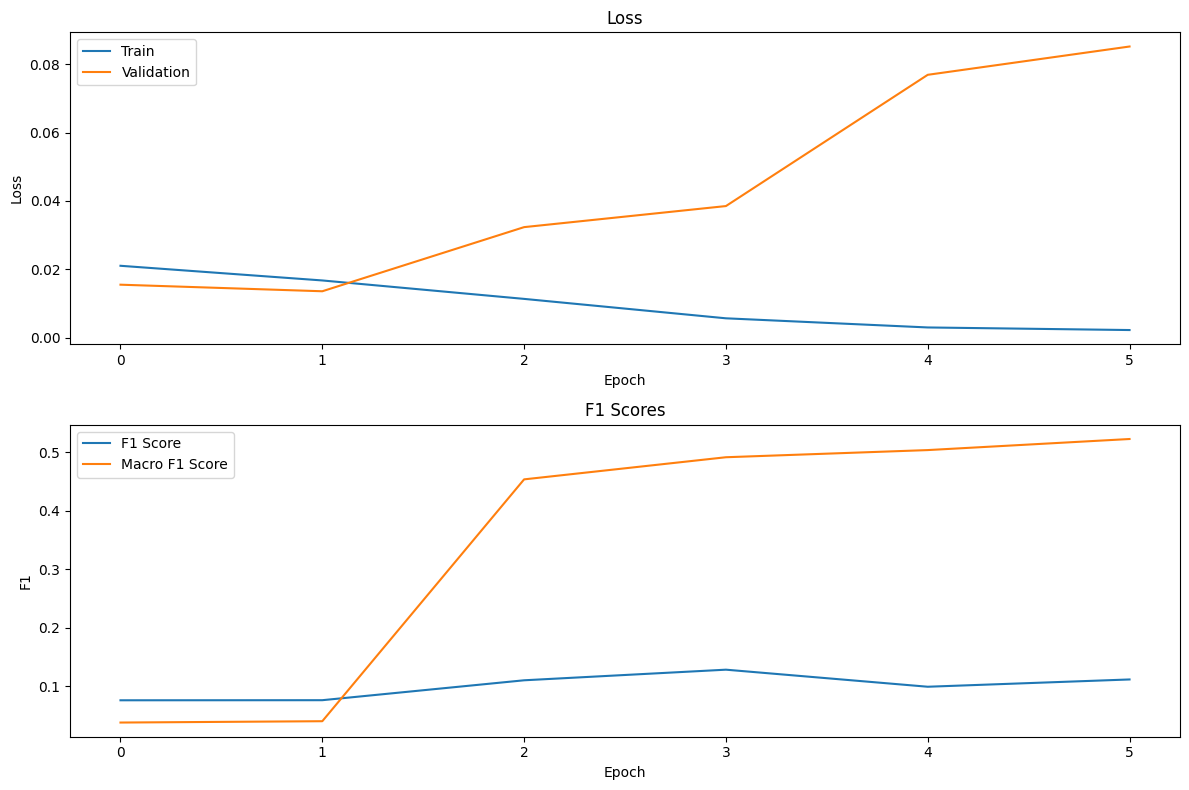

In [23]:
# Plot training history
plt.figure(figsize=(12, 8))

# Plot loss
plt.subplot(2, 1, 1)
plt.plot(history['train_loss'][:6], label='Train')
plt.plot(history['val_loss'][:6], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot F1 scores
plt.subplot(2, 1, 2)
plt.plot(history['val_f1'][:6], label='F1 Score')
plt.plot(history['val_macro_f1'][:6], label='Macro F1 Score')
plt.title('F1 Scores')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/loss_f1.png')
plt.show()

